## GENERATIVE ADVERSARIAL NETWORK

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
import tensorflow
import tensorflow as tf
print(tf.__version__)

import keras
import keras.backend as K

from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras import layers, models
from keras.optimizers import Adam
from keras.layers import Conv2D, BatchNormalization, Flatten, Dense
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization
import matplotlib.pyplot as plt
from time import time
import cv2
import os
import glob
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings('ignore')

2.15.0


In [14]:
AnnualCrop_sat = 'DATASET/TRAIN/AnnualCrop_sat'
Bridge_aerial = 'DATASET/TRAIN/Bridge_aerial'
damage = 'DATASET/TRAIN/damage'
Forest_sat = 'DATASET/TRAIN/Forest_sat'
Highway_sat = 'DATASET/TRAIN/Highway_sat'
Industrial_aerial = 'DATASET/TRAIN/Industrial_aerial'

In [15]:
def plot_images(item_dir, n=6):
    all_item_dir = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dir][:n]
    
    plt.figure(figsize=(80, 40))
    for idx, img_path in enumerate(item_files):
        plt.subplot(3, n, idx+1)
        img = plt.imread(img_path)
        plt.imshow(img, cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    
def image_details_print(data,path):
    print('======== Images in: ', path)
    for key,values in data.items():
        print(key,':\t', values)


def images_details(path):
    files=[f for f in glob.glob(path + "**/*.*", recursive=True)]
    data={}
    data['Images_count']=len(files)
    data['Min_width']=10**100
    data['Max_width']=0
    data['Min_height']=10**100
    data['Max_height']=0
    
    for f in files:
        img=Image.open(f)
        width,height=img.size
        data['Min_width']=min(width,data['Min_width'])
        data['Max_width']=max(width, data['Max_width'])
        data['Min_height']=min(height, data['Min_height'])
        data['Max_height']=max(height, data['Max_height'])
        
    image_details_print(data,path)


TRAINING DATA FOR AnnualCrop_sat:

======== Images in:  DATASET/TRAIN/AnnualCrop_sat
Images_count :	 100
Min_width :	 64
Max_width :	 64
Min_height :	 64
Max_height :	 64



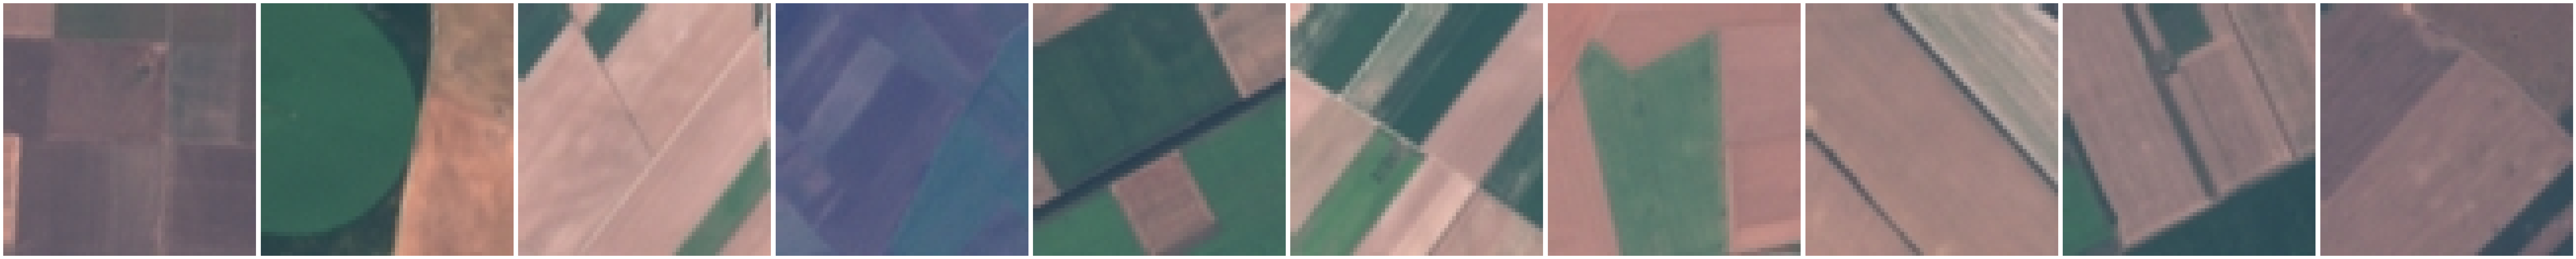

In [16]:
print("")
print("TRAINING DATA FOR AnnualCrop_sat:")
print("")
images_details(AnnualCrop_sat)
print("")
plot_images(AnnualCrop_sat, 10) 


TRAINING DATA FOR Bridge_aerial:

======== Images in:  DATASET/TRAIN/Bridge_aerial
Images_count :	 100
Min_width :	 256
Max_width :	 256
Min_height :	 256
Max_height :	 256



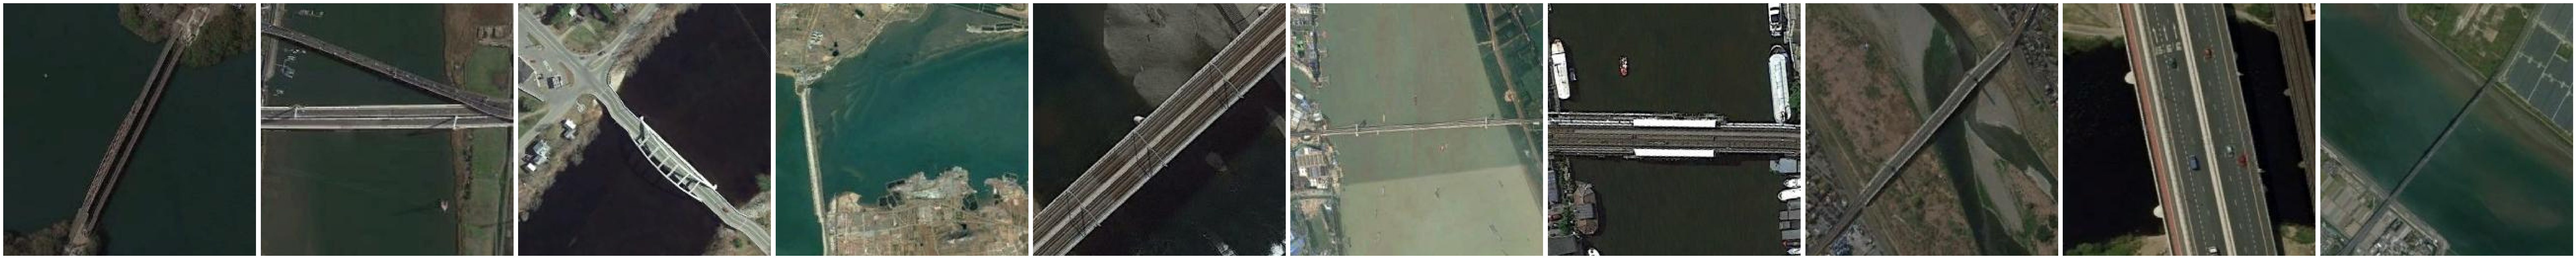

In [17]:
print("")
print("TRAINING DATA FOR Bridge_aerial:")
print("")
images_details(Bridge_aerial)
print("")
plot_images(Bridge_aerial, 10) 


TRAINING DATA FOR damage:

======== Images in:  DATASET/TRAIN/damage
Images_count :	 100
Min_width :	 128
Max_width :	 128
Min_height :	 128
Max_height :	 128



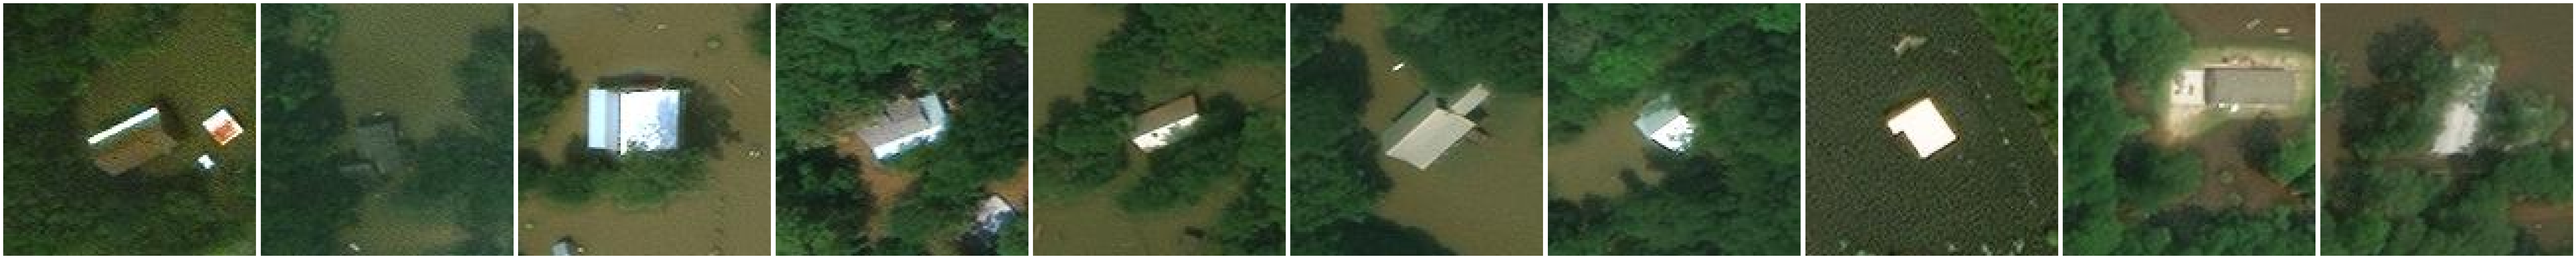

In [18]:
print("")
print("TRAINING DATA FOR damage:")
print("")
images_details(damage)
print("")
plot_images(damage, 10)

In [3]:
tf.keras.backend.clear_session()
tf.compat.v1.disable_eager_execution()
tf.config.set_visible_devices([], 'GPU')

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train=ImageDataGenerator(rescale=1./255,shear_range=0.2,zoom_range=0.2,horizontal_flip=True,validation_split = 0.2)
train_data=train.flow_from_directory(directory = 'DATASET/TRAIN',target_size=(64,64),
                                     batch_size=32,class_mode='categorical')

Found 2506 images belonging to 20 classes.


In [5]:
test=ImageDataGenerator(rescale=1./255)
test_data = test.flow_from_directory(directory = 'DATASET/TEST',target_size=(64,64),
                                   batch_size=32,class_mode='categorical')

Found 2505 images belonging to 20 classes.


In [6]:
# Define image dimensions
height = 64
width = 64
channels = 3    # Assuming RGB images


In [7]:
def build_generator():

    model = models.Sequential()
    model.add(layers.Dense(7 * 7 * 256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return model

# Discriminator model
def build_discriminator():
    model = models.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

# GAN model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential([generator, discriminator])
    return model

# Compile the discriminator
discriminator = build_discriminator()
discriminator.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

# Compile the generator
generator = build_generator()

# Compile the GAN
discriminator.trainable = False
gan = build_gan(generator, discriminator)
gan.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5),
            loss='binary_crossentropy')


input_shape = (224, 224, 3)
n_classes = 20
K.clear_session()
generator = build_generator()
discriminator = build_discriminator()
model = build_gan(generator, discriminator)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 28, 28, 1)         2330944   
                                                                 
 sequential_1 (Sequential)   (None, 1)                 212865    
                                                                 
Total params: 2543809 (9.70 MB)
Trainable params: 2305472 (8.79 MB)
Non-trainable params: 238337 (931.00 KB)
_________________________________________________________________


In [8]:
model = models.Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, channels)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(BatchNormalization(axis=-1))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))

# Add a Flatten layer before BatchNormalization
model.add(Flatten())

# The rest of your model remains the same
model.add(BatchNormalization(axis=-1))
model.add(Dense(64, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))


In [9]:
model_path = "GAN.h5"

from keras.callbacks import ModelCheckpoint

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# Display the model summary to verify the architecture
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 flatten_1 (Flatten)         (None, 30752)             0         
                                                                 
 batch_normalization_3 (Bat  (None, 30752)             123008    
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 64)                1968192   
                                                                 
 dense_3 (Dense)             (None, 20)              

In [10]:
checkpoint = ModelCheckpoint(
    model_path,
    monitor='accuracy',  # You can change this to the metric you want to monitor
    save_best_only=True,      # Save only the best model
    mode='max',               # 'max' if monitoring accuracy, 'min' if monitoring loss
    verbose=1
)

In [11]:
batch_size = 8
epochs = 100

In [12]:
# Fit the model
history = model.fit(
    train_data,
    steps_per_epoch=train_data.samples // batch_size,
    epochs=epochs,
    validation_data=test_data,
    validation_steps=test_data.samples // batch_size,
    callbacks=[checkpoint]
)


Epoch 1/100

313/313 [==============================] - ETA: 0s - batch: 156.0000 - size: 31.7188 - loss: 2.4808 - accuracy: 0.2167    
Epoch 1: accuracy improved from -inf to 0.21666, saving model to GAN.h5
313/313 [==============================] - 70s 221ms/step - batch: 156.0000 - size: 31.7188 - loss: 2.4808 - accuracy: 0.2167 - val_loss: 2.7602 - val_accuracy: 0.1563
Epoch 2/100
313/313 [==============================] - ETA: 0s - batch: 156.0000 - size: 31.7188 - loss: 2.2837 - accuracy: 0.2774   
Epoch 2: accuracy improved from 0.21666 to 0.27740, saving model to GAN.h5
313/313 [==============================] - 34s 109ms/step - batch: 156.0000 - size: 31.7188 - loss: 2.2837 - accuracy: 0.2774 - val_loss: 2.7149 - val_accuracy: 0.1781
Epoch 3/100
313/313 [==============================] - ETA: 0s - batch: 156.0000 - size: 31.7188 - loss: 2.2481 - accuracy: 0.2916   
Epoch 3: accuracy improved from 0.27740 to 0.29160, saving model to GAN.h5
313/313 [============================

In [13]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

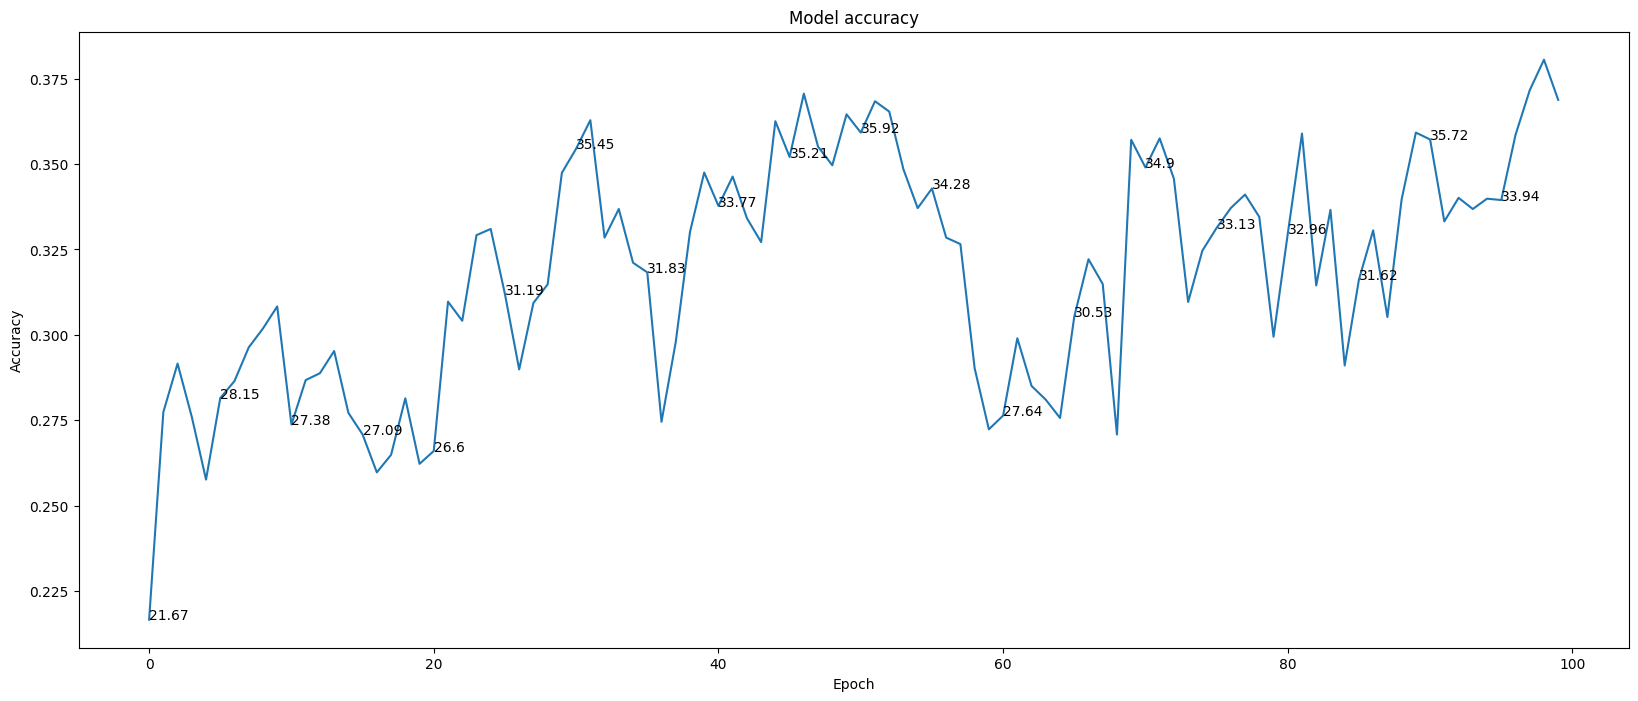

In [14]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20, 8))
plt.plot(history.history['accuracy'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['accuracy'][i]*100,2),xy=(i,history.history['accuracy'][i]))

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.show()

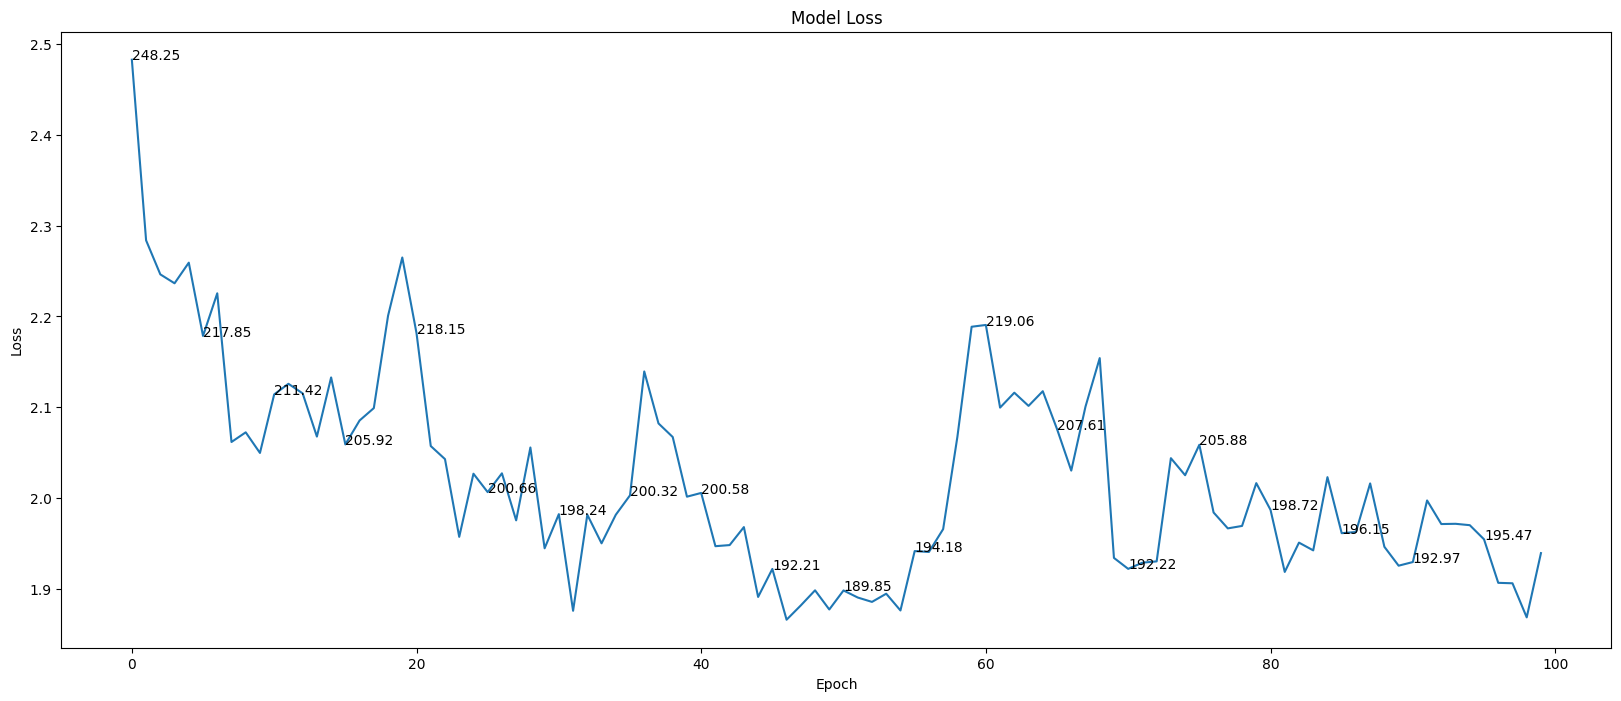

In [15]:
plt.figure(figsize=(20, 8))
plt.plot(history.history['loss'])

for i in range(epochs):
    if i%5 == 0:
        plt.annotate(np.round(history.history['loss'][i]*100,2),xy=(i,history.history['loss'][i]))

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()